In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from myusefultools.pyopenfoam import OpenFOAM
from pathlib import Path
import multiprocessing as mp
import os
import itertools

In [2]:
## Check CASES folder exists
cases_folder = Path("CASES")
if not cases_folder.exists():
    os.mkdir(cases_folder)

template_folder = Path("template")

In [3]:
rho_x_list = [1, 10, 100, 1000]
d_growth_list = [1e-10]
cases_objs = dict()

## Assemble cases
for rho_x, d_growth in itertools.product(
    rho_x_list, d_growth_list
):

    identifier = f"CASES/rhox_{rho_x}__dgrowth_{d_growth}"
    of = OpenFOAM(
        path_case=identifier, write_to_log = True, path_template=template_folder
    )

    of.set_value_in_foamDictionary(
        location="constant/transportProperties", 
        entry="rho_X",
        value=f"rho_X   [1 -3 0 0 0 0 0] {rho_x:.1f}")
    
    of.set_value_in_foamDictionary(
        location="constant/transportProperties", 
        entry="diffusiveGrowth",
        value=f"diffusiveGrowth [0 2 -1 0 0 0 0] {d_growth:.2e}")

    cases_objs[identifier] = of

In [4]:
cases_objs["CASES/rhox_10__dgrowth_1e-10"]

OpenFOAM(path_case=PosixPath('CASES/rhox_10__dgrowth_1e-10'), path_template=PosixPath('template'), write_to_log=True)

In [5]:
with mp.Pool(processes=24) as pool:
    pool.map(OpenFOAM.run_solver, cases_objs.values())

In [6]:
with mp.Pool() as pool:
    pool.map(OpenFOAM.foam_to_vtk, cases_objs.values())

with mp.Pool() as pool:
    pool.map(OpenFOAM.boundaryProbes_to_txt, cases_objs.values())

In [7]:
import json

field = "XAR"

with open("heatmaps_config.json") as f:
    heatmaps_config = json.load(f)

default_pcolormesh_kwargs = dict(vmin=0, cmap="winter")
pcolormesh_kwargs = heatmaps_config.get(field) or default_pcolormesh_kwargs

# with mp.Pool() as pool:
#     figs = pool.starmap(
#         OpenFOAM.plot_field_over_time,
#         [(of, field, pcolormesh_kwargs) for of in cases_objs.values()],
#     )

In [8]:
field = "XAR"

with mp.Pool() as pool:
    data = pool.starmap(
        OpenFOAM.read_field_all_times,
        [(of, field) for of in cases_objs.values()],
    )

In [9]:
data[0].t

<xarray.DataArray 't' (t: 116)>
array([  17272.485,   34552.485,   51832.485,   69112.485,   86392.485,
        103672.485,  120952.485,  138232.485,  155512.485,  172792.485,
        190072.485,  207352.485,  224632.485,  241912.485,  259192.485,
        276472.485,  293752.485,  311032.485,  328312.485,  345592.485,
        362872.485,  380152.485,  397432.485,  414712.485,  431992.485,
        449272.485,  466552.485,  483832.485,  501112.485,  518392.485,
        535672.485,  552952.485,  570232.485,  587512.485,  604792.485,
        622072.485,  639352.485,  656632.485,  673912.485,  691192.485,
        708472.485,  725752.485,  743032.485,  760312.485,  777592.485,
        794872.485,  812152.485,  829432.485,  846712.485,  863992.485,
        881272.485,  898552.485,  915832.485,  933112.485,  950392.485,
        967672.485,  984952.485, 1002232.485, 1019512.485, 1036792.485,
       1054072.485, 1071352.485, 1088632.485, 1105912.485, 1123192.485,
       1140472.485, 1157752.485, 1175032.485, 1192312.485, 1209592.485,
       1226872.485, 1244152.485, 1261432.485, 1278712.485, 1295992.485,
       1313272.485, 1330552.485, 1347832.485, 1365112.485, 1382392.485,
       1399672.485, 1416952.485, 1434232.485, 1451512.485, 1468792.485,
       1486072.485, 1503352.485, 1520632.485, 1537912.485, 1555192.485,
       1572472.485, 1589752.485, 1607032.485, 1624312.485, 1641592.485,
       1658872.485, 1676152.485, 1693432.485, 1710712.485, 1727992.485,
       1745272.485, 1762552.485, 1779832.485, 1797112.485, 1814392.485,
       1831672.485, 1848952.485, 1866232.485, 1883512.485, 1900792.485,
       1918072.485, 1935352.485, 1952632.485, 1969912.485, 1987192.485,
       1987200.   ])
Coordinates:
  * t        (t) float64 1.727e+04 3.455e+04 5.183e+04 ... 1.987e+06 1.987e+06

In [10]:
labels = cases_objs.keys()
labels

dict_keys(['CASES/rhox_1__dgrowth_1e-10', 'CASES/rhox_10__dgrowth_1e-10', 'CASES/rhox_100__dgrowth_1e-10', 'CASES/rhox_1000__dgrowth_1e-10'])

In [11]:
import matplotlib as mpl
from itertools import cycle

cmap = mpl.cm.Dark2
# colors = cmap(range(len(d_growth_list)))  # Colors to differentiate d_growth
colors = ['#a1dab4','#41b6c4','#2c7fb8','#253494']

In [12]:
# 🏁 End of experiment results
cfu = pd.read_excel("../experimentalData/.hiddendata/Live-counts.xlsx", sheet_name="Inoculated")
cfu

,Sample,Depth (cm),z (m),#1,#2,#3,CFU/mL,stdev,Tara+Sand,Tara,dry sand,CFU/g dry sand
0,1-0,0.0,0.600,2410000000,4.600000e+09,NaN,3.505000e+09,1.548564e+09,6.2530,5.3186,0.9344,3.751070e+09
1,1-1,2.5,0.575,92000000,1.600000e+08,NaN,1.260000e+08,4.808326e+07,6.1292,5.3068,0.8224,1.532101e+08
2,1-2,7.5,0.525,286000000,3.100000e+08,600000000.0,3.986667e+08,1.747722e+08,6.3179,5.2936,1.0243,3.892089e+08
3,1-3,12.5,0.475,42000000,NaN,NaN,4.200000e+07,NaN,6.2131,5.2882,0.9249,4.541031e+07
4,1-4,17.5,0.425,38400000,5.400000e+07,20000000.0,3.746667e+07,1.701920e+07,6.2205,5.2526,0.9679,3.870923e+07
5,1-5,22.5,0.375,120000000,4.000000e+07,NaN,8.000000e+07,5.656854e+07,6.3632,5.3267,1.0365,7.718283e+07
6,1-6,27.5,0.325,98000000,1.300000e+08,NaN,1.140000e+08,2.262742e+07,6.3692,5.2921,1.0771,1.058398e+08


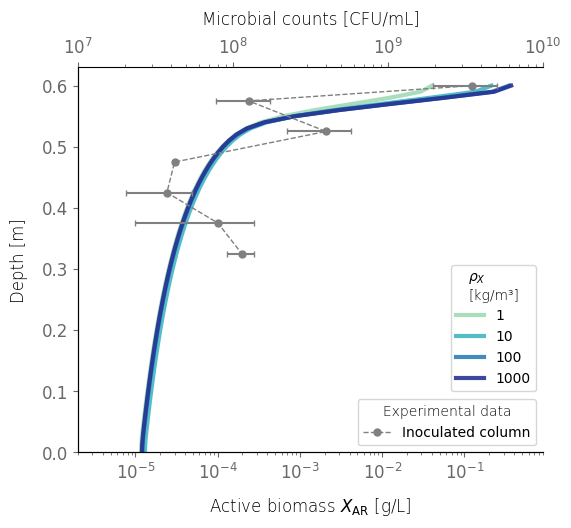

In [22]:
from matplotlib.ticker import LogLocator
import re

pattern = r"_(\d+)_"

fig, ax = plt.subplots(figsize=(6,5), dpi=100)
display_label = False
dvalues = list()

for experiment, label, color in zip(data, labels, cycle(colors)):        
        dvalue = re.findall(pattern, label)[0]

        if not dvalue in dvalues:
            l, = ax.plot(experiment.isel(t=-1), experiment.z, 
                c=color, alpha=0.9, lw=3)
            l.set_label(dvalue)
            dvalues.append(dvalue)
     
    # break 

ax.set_xscale("log")
ax.set_xlim(2e-6, 9e-1)
ax.set_ylim(bottom=0)
ax.set_ylabel("Depth [m]")
ax.set_xlabel(r"Active biomass $X_{\mathsf{AR}}$ [g/L]")
ax.xaxis.set_major_locator(LogLocator())
ax.xaxis.set_minor_locator(LogLocator(subs="all"))
ax.legend(title=r"$\rho_X$""\n[kg/m³]", title_fontproperties=dict(size=10, weight=100), loc="lower right", bbox_to_anchor=(1, 0.14))
# ax.tick_params(axis="both", which="minor", width=1, length=10, color="k")


ax2 = ax.twiny()
ax2.errorbar(cfu["CFU/mL"], cfu["z (m)"], xerr=cfu["stdev"], fmt="none", ecolor="gray", capsize=2)
ax2.plot(cfu["CFU/mL"], cfu["z (m)"], marker="o", markersize=5, c="gray", lw=1, ls="dashed", label="Inoculated column")
ax2.set_xscale("log")
ax2.set_ylim(ax.get_ylim())
ax2.spines.top.set_visible(True)
ax2.set_xlim(1e+7, 1e+10)
ax2.set_xlabel(r"Microbial counts [CFU/mL]")
leg = ax2.legend(title="Experimental data", title_fontproperties=dict(size=10, weight=100), loc="lower right")
fig.savefig("XAR by rhoX.pdf", bbox_inches='tight')
plt.show()

In [15]:
for of in cases_objs.values():
    of.process_boundaryProbes()

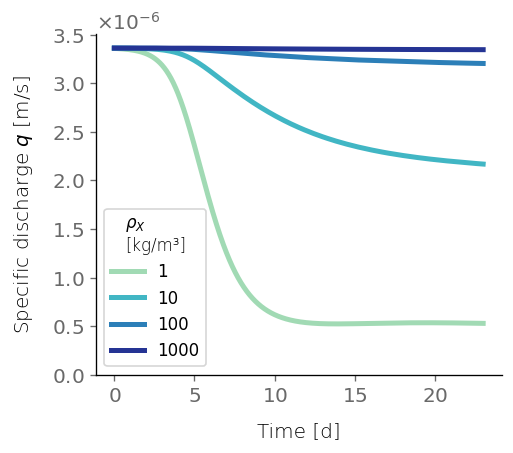

In [31]:
fig, ax = plt.subplots(figsize=[4.5, 4], dpi=120)

for (label, of), color in zip(cases_objs.items(), cycle(colors)):
    for bp in of.boundaryProbes:  ## Probe for vector data, another for scalar data
        for k, v in bp.array_data.items():
            if k == "Uz":
                # match = re.search(pattern, label)
                # if match: labeltext = f"$\\rho_X$ = {match.group()}, $D_g$ = {label[-5:]}"
                ax.plot(
                    v.time/86400, - v.values[0], 
                    label=re.findall(pattern, label)[0], 
                    c=color, lw=3)
                # v.plot.line(x="time", ax=ax, lw=1, label=label)
ax.legend(loc="lower left", bbox_to_anchor=(0, 0), title=r"$\rho_X$""\n[kg/m³]", title_fontproperties=dict(size=10, weight=100))

ax.set_ylim(bottom=0)
ax.set_xlabel("Time [d]")
ax.set_ylabel("Specific discharge $q$ [m/s]")
ax.ticklabel_format(useMathText=True)
fig.tight_layout()
plt.show()